In [ ]:
import os
import pandas as pd
import numpy as np
from numpy import expand_dims
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.transform import resize
from IPython.display import SVG
from tensorflow import keras
from tensorflow.keras import applications
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.utils import to_categorical, model_to_dot, plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau

In [ ]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import cv2
import random
from tensorflow import keras
from keras.layers import Dense, Input, InputLayer, Flatten
from keras.models import Sequential, Model
from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [ ]:
IMG_WIDTH, IMG_HEIGHT = 80, 80 
channels = 3
batch_size = 64
num_images= 50
image_arr_size= IMG_WIDTH * IMG_HEIGHT * channels

In [ ]:
import tensorflow as tf
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError: # If TPU not found
  tpu = None

# Select appropriate distribution strategy
if tpu:
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])  
else:
  tpu_strategy = tf.distribute.get_strategy() # Default strategy that works on CPU and single GPU
  print('Running on CPU instead')
print("Number of accelerators: ", tpu_strategy.num_replicas_in_sync)  

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Load The Stanford Dogs Dataset**
The Stanford Dogs Dataset contains images of 120 breeds of dogs from around the world. This dataset has been built using images and annotation from ImageNet for the task of fine-grained image categorization.
Contents of the dataset:

Number of categories: 120
Number of images: 20,580
Annotations: Class labels, Bounding boxes

The dataset can be downloaded from http://vision.stanford.edu/aditya86/ImageNetDogs/.

In [ ]:
def create_dataset(dataset_folder):  
    img_data_array=[]
    class_name=[]
   
    for dir1 in os.listdir(dataset_folder):
        print(dir1)
        for file in os.listdir(os.path.join(dataset_folder, dir1)):
       
            image_path= os.path.join(dataset_folder, dir1,  file)
            image= cv2.imread( image_path, cv2.COLOR_BGR2RGB)
            image=cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH),interpolation = cv2.INTER_AREA)
            image=np.array(image)
            image = image.astype('float32')
            image = (image-127.5) / 127.5 
            img_data_array.append(image)
            class_name.append(dir1)
    return img_data_array, class_name

In [ ]:
dataset_folder=r'/content/drive/MyDrive/Stanford_Dogs_dataset/Images/'
img_data, class_name = create_dataset(dataset_folder)

n02088238-basset
n02085782-Japanese_spaniel
n02086910-papillon
n02085620-Chihuahua
n02088094-Afghan_hound
n02087046-toy_terrier
n02086240-Shih-Tzu
n02087394-Rhodesian_ridgeback
n02086646-Blenheim_spaniel
n02086079-Pekinese
n02085936-Maltese_dog
n02088364-beagle
n02088632-bluetick
n02089078-black-and-tan_coonhound
n02089867-Walker_hound
n02090379-redbone
n02090622-borzoi
n02091032-Italian_greyhound
n02091134-whippet
n02091467-Norwegian_elkhound
n02091831-Saluki
n02092339-Weimaraner
n02093256-Staffordshire_bullterrier
n02093428-American_Staffordshire_terrier
n02093647-Bedlington_terrier
n02093754-Border_terrier
n02093991-Irish_terrier
n02094258-Norwich_terrier
n02094433-Yorkshire_terrier
n02095314-wire-haired_fox_terrier
n02095570-Lakeland_terrier
n02095889-Sealyham_terrier
n02096051-Airedale
n02096177-cairn
n02096437-Dandie_Dinmont
n02096585-Boston_bull
n02097047-miniature_schnauzer
n02097130-giant_schnauzer
n02097298-Scotch_terrier
n02097474-Tibetan_terrier
n02097658-silky_terrier
n020

In [ ]:
x = np.asarray(img_data)
print(x.shape)

(20580, 80, 80, 3)


In [ ]:
target_dict={k: v for v, k in enumerate(np.unique(class_name))}
target_dict

{'n02085620-Chihuahua': 0,
 'n02085782-Japanese_spaniel': 1,
 'n02085936-Maltese_dog': 2,
 'n02086079-Pekinese': 3,
 'n02086240-Shih-Tzu': 4,
 'n02086646-Blenheim_spaniel': 5,
 'n02086910-papillon': 6,
 'n02087046-toy_terrier': 7,
 'n02087394-Rhodesian_ridgeback': 8,
 'n02088094-Afghan_hound': 9,
 'n02088238-basset': 10,
 'n02088364-beagle': 11,
 'n02088466-bloodhound': 12,
 'n02088632-bluetick': 13,
 'n02089078-black-and-tan_coonhound': 14,
 'n02089867-Walker_hound': 15,
 'n02089973-English_foxhound': 16,
 'n02090379-redbone': 17,
 'n02090622-borzoi': 18,
 'n02090721-Irish_wolfhound': 19,
 'n02091032-Italian_greyhound': 20,
 'n02091134-whippet': 21,
 'n02091244-Ibizan_hound': 22,
 'n02091467-Norwegian_elkhound': 23,
 'n02091635-otterhound': 24,
 'n02091831-Saluki': 25,
 'n02092002-Scottish_deerhound': 26,
 'n02092339-Weimaraner': 27,
 'n02093256-Staffordshire_bullterrier': 28,
 'n02093428-American_Staffordshire_terrier': 29,
 'n02093647-Bedlington_terrier': 30,
 'n02093754-Border_terr

In [ ]:
target_val=  [target_dict[class_name[i]] for i in range(len(class_name))]
y=np.array(list(map(int,target_val)), np.float32)
y = to_categorical(y, num_classes=len(target_dict), dtype="float32")

In [ ]:
y.shape

(20580, 120)

In [ ]:
from sklearn.utils import shuffle
x, y = shuffle(x, y)

In [ ]:
x_train = x[:16000]
x_val = x[16000:]
y_train = y[:16000]
y_val = y[16000:]

In [ ]:
print(x_train.shape, x_val.shape, y_train.shape, y_val.shape)

(16000, 80, 80, 3) (4580, 80, 80, 3) (16000, 120) (4580, 120)


# **Preprocessing**

In [ ]:
train_datagen = ImageDataGenerator(
    shear_range= 0.2,
    zoom_range= 0.2,
    horizontal_flip= True,
    rotation_range= 20,
    width_shift_range= 0.2,
    height_shift_range= 0.2,   
    validation_split=0.2,

)

valid_datagen = ImageDataGenerator(
    validation_split=0.2,
)

In [ ]:
train_generator = train_datagen.flow(  
    x_train, y_train,  
    batch_size= batch_size,  
    subset='training',
    shuffle= True
) 

valid_generator = valid_datagen.flow(
    x_val, y_val,
    batch_size= batch_size,  
    subset='validation',
    shuffle= True
)

In [ ]:
num_classes = len(class_name)  
train_labels = class_name
valid_labels = class_name
nb_train_samples = len(y_train)  
nb_valid_samples = len(y_val)

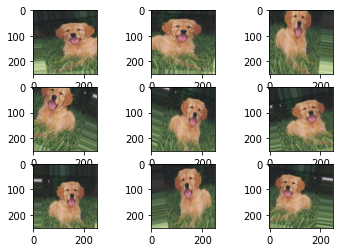

In [ ]:
img = load_img('/content/drive/MyDrive/Stanford_Dogs_dataset/Images/n02099601-golden_retriever/n02099601_5.jpg')
data = img_to_array(img)
data = (data)/255
samples = expand_dims(data, 0)
it = train_datagen.flow(samples, batch_size=1)

for i in range(9):
    plt.subplot(330 + 1 + i)
    batch = it.next()
    image = batch[0]
    plt.imshow(image)

plt.savefig('augmented_image.png', transparent= False, bbox_inches= 'tight', dpi= 900)
plt.show()

# **InceptionV3 Model**

In [ ]:
InceptionV3 = applications.InceptionV3(include_top= False, input_shape= (IMG_WIDTH, IMG_HEIGHT, channels), weights= 'imagenet')
# Rsnet50 = tf.keras.applications.ResNet50(weights='imagenet',
#                                                 include_top = False, 
#                                                 input_shape= (IMG_WIDTH, IMG_HEIGHT, channels))
model = Sequential()

for layer in InceptionV3.layers:
    layer.trainable= False
#     print(layer,layer.trainable)
    
model.add(InceptionV3)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.2))
model.add(Dense(len(target_dict),activation='softmax'))
model.summary()

87924736/87910968 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 1, 1, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 120)               245880    
                                                                 
Total params: 22,048,664
Trainable params: 245,880
Non-trainable params: 21,802,784
_________________________________________________________________


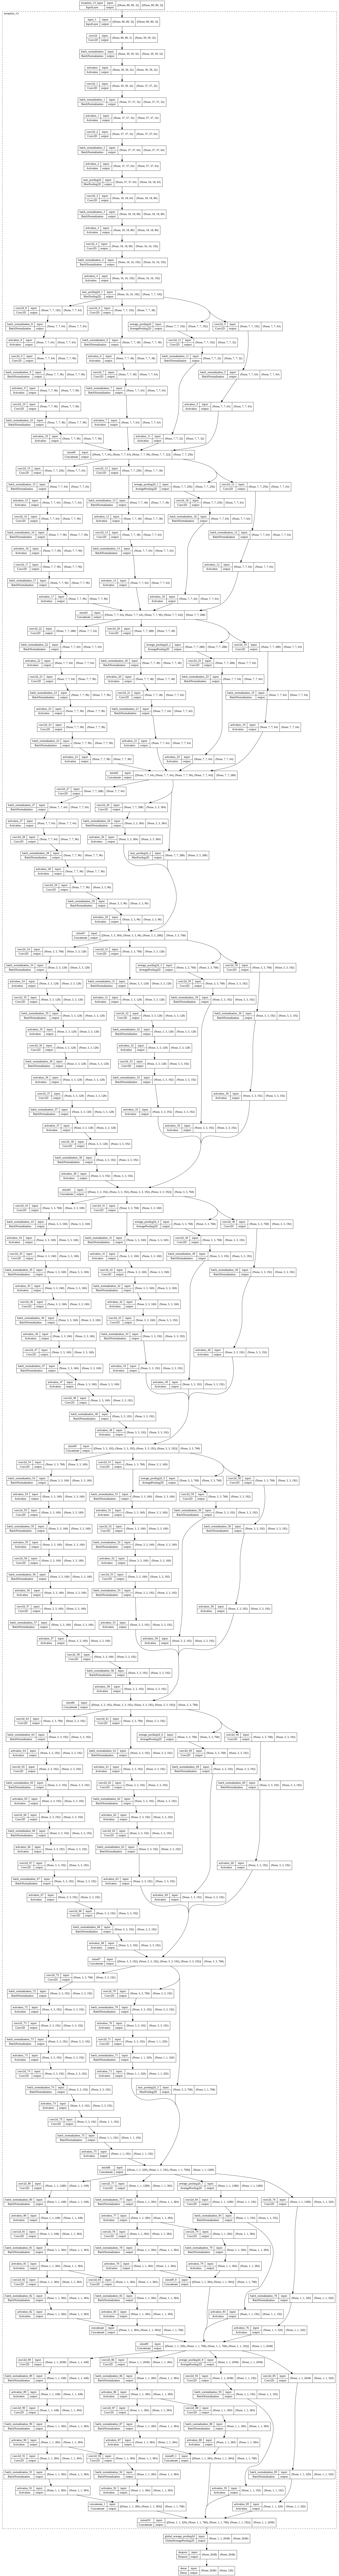

In [ ]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, expand_nested=True)

# **Baseline Model Training**

In [ ]:
model.compile(optimizer= keras.optimizers.Adam(learning_rate= 0.0001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [ ]:
nb_train_samples//batch_size

500

In [ ]:
history = model.fit(
  train_generator, 
  epochs = 100,
  steps_per_epoch = nb_train_samples//batch_size,
  validation_data = valid_generator, 
  validation_steps = nb_valid_samples//batch_size,
  verbose = 2, 
  # callbacks = callbacks,
  shuffle = True)

Epoch 1/100
250/250 - 22s - loss: 4.6364 - accuracy: 0.0641 - val_loss: 4.3802 - val_accuracy: 0.0841 - 22s/epoch - 89ms/step
Epoch 2/100
250/250 - 21s - loss: 4.5847 - accuracy: 0.0681 - 21s/epoch - 82ms/step
Epoch 3/100
250/250 - 21s - loss: 4.5236 - accuracy: 0.0774 - 21s/epoch - 82ms/step
Epoch 4/100
250/250 - 21s - loss: 4.4420 - accuracy: 0.0822 - 21s/epoch - 83ms/step
Epoch 5/100
250/250 - 21s - loss: 4.4243 - accuracy: 0.0830 - 21s/epoch - 86ms/step
Epoch 6/100
250/250 - 21s - loss: 4.3424 - accuracy: 0.0910 - 21s/epoch - 83ms/step
Epoch 7/100
250/250 - 21s - loss: 4.2812 - accuracy: 0.0997 - 21s/epoch - 83ms/step
Epoch 8/100
250/250 - 21s - loss: 4.2838 - accuracy: 0.1028 - 21s/epoch - 86ms/step
Epoch 9/100
250/250 - 21s - loss: 4.2522 - accuracy: 0.0970 - 21s/epoch - 82ms/step
Epoch 10/100
250/250 - 21s - loss: 4.2319 - accuracy: 0.1002 - 21s/epoch - 82ms/step
Epoch 11/100
250/250 - 21s - loss: 4.1913 - accuracy: 0.1051 - 21s/epoch - 82ms/step
Epoch 12/100
250/250 - 21s - los

In [ ]:
(eval_loss, eval_accuracy) = model.evaluate(valid_generator, batch_size= batch_size, verbose= 1)
print('Validation Loss: ', eval_loss)
print('Validation Accuracy: ', eval_accuracy)

29/29 [==============================] - 2s 53ms/step - loss: 3.7557 - accuracy: 0.1725
Validation Loss:  3.7556686401367188
Validation Accuracy:  0.17248907685279846


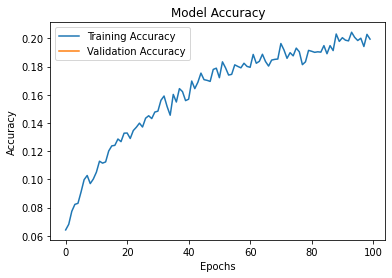

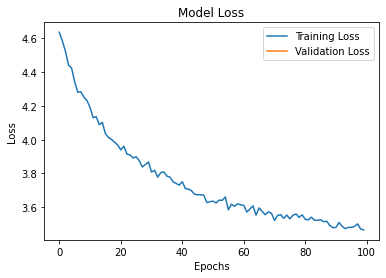

In [ ]:
plt.subplot()
plt.title('Model Accuracy')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training Accuracy','Validation Accuracy'])
plt.savefig('baseline_acc_epoch.png', transparent= False, bbox_inches= 'tight', dpi= 900)
plt.show()

plt.title('Model Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training Loss','Validation Loss'])
plt.savefig('baseline_loss_epoch.png', transparent= False, bbox_inches= 'tight', dpi= 900)
plt.show()

In [ ]:
model_path = "/content/drive/MyDrive/"
model.save(model_path+"InceptionV3_isolated_model_stanford_dogs_80x80x3.h5")